In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from scipy.signal import TransferFunction, lsim, tf2ss

import scipy
import os
import control

SAVE_PATH = 'report/figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
plt.rcParams['figure.figsize'] = [4, 4]

In [2]:
# var 17
a_1, a_0 = 2, 4
b_1, b_0 = 3, 5
k_1, k_0 = 4, 4
g = lambda t : np.sin(t) + 0.5 * np.cos(2 * t) 

# Task 1

In [3]:
theta = np.array([k_0 - a_0, k_1 - a_1, b_0, b_1])

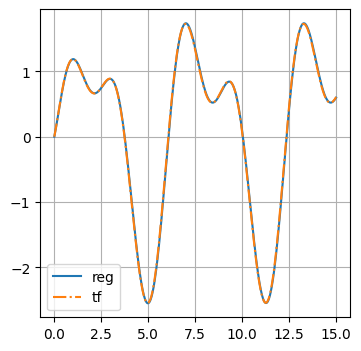

In [4]:
class OutputRegression():
    def __init__(self, denum_ks, n, m, y0, u0, theta) -> None:
        u0 = np.array([u0])
        parts = y0 / sum(theta**2)
        self.n = n
        self.m = m
        self.num = [1]
        self.denum_ks = denum_ks
        self.omega = [tf2ss(self.num + [0] * i, denum_ks) for i in range(n)]
        self.omega += [tf2ss(self.num + [0] * i, denum_ks) for i in range(m)]
        self.systems_xs = []
        self.y = np.array([y0]).reshape(1, 1)
        parts = np.array([parts]).reshape(1, 1)
        for i in range(self.n):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
        for i in range(self.n, self.n + self.m):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
    
    def model(self, ts, us, theta):
        ys = np.zeros(self.m + self.n)
        dt = ts[1] - ts[0]
        res = [self.y.reshape(-1)[-1]]
        for idx in range(len(ts) - 1):
            for i in range(self.n):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * self.y
                ys[i] = (C @ self.systems_xs[i] + D @ self.y).reshape(-1)[-1]
            for i in range(self.n, self.n + self.m):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * us[idx]
                ys[i] = (C @ self.systems_xs[i] + D * u[idx]).reshape(-1)[-1]
            res.append(theta.T @ ys)
            self.y = np.array(res[-1]).reshape(1, 1)
        return res

ts = np.linspace(0, 15, 1000)
u = g(ts).reshape((len(ts), 1))

y0 = 0
ov = OutputRegression(denum_ks=[1, k_1, k_0], n=2, m=2, y0=y0, u0=u[0], theta=theta)
res = ov.model(ts, u, theta)
plt.plot(ts, res, label='reg')

sptf = TransferFunction([b_1, b_0], [1, a_1, a_0])
A, B, C, D = tf2ss([b_1, b_0], [1, a_1, a_0])
x0 = np.linalg.pinv(C) @ (np.array([y0]) - D * 1)
t, y, x = lsim(sptf, U=u, T=ts, X0=x0.reshape(-1))
plt.plot(t, y, '-.', label='tf')
plt.legend()
plt.grid()

# Task 2

In [20]:
ssA = np.array([[-a_1, 1], [-a_0, 0]])
A_0 = np.array([[-k_1, 1], [-k_0, 0]]) 
ssB = np.array([b_1, b_0]).reshape((A.shape[0], 1))
ssC = np.zeros((1, ssA.shape[0]))
ssC[0] += 1 
ssD = np.zeros((1, ssB.shape[1]))

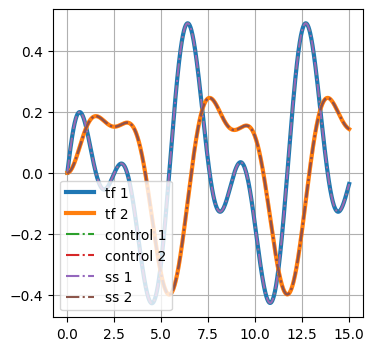

In [24]:
A, B, C, D = tf2ss([b_1, b_0], [1, a_1, a_0])
t, y, x = lsim((A, B, C, D), U=u, T=ts)
plt.plot(t, x, label=['tf 1', 'tf 2'], linewidth=3)
u = g(ts).reshape((len(ts), 1))

ss = control.ss(ssA, ssB, ssC, ssD)
ss = control.reachable_form(ss)[0]
res = control.forced_response(ss, U=u.T, T=ts)

plt.plot(t, res.states.T, '-.', label=['control 1', 'control 2'])
t, y, x = lsim((ss.A, ss.B, ss.C, ss.D), U=u, T=ts)
plt.plot(t, x, '-.', label=['ss 1', 'ss 2'])
plt.legend()
plt.grid()

In [26]:
ss.A, ssA

(array([[-2., -4.],
        [ 1.,  0.]]),
 array([[-2,  1],
        [-4,  0]]))

In [7]:
import sympy
from sympy.abc import s
sympy.Matrix([[s + 1, -1, 0], [1, s, 0], [1, 0, s]]).inv()

Matrix([
[ s/(s**2 + s + 1),     -1/(-s**2 - s - 1),   0],
[1/(-s**2 - s - 1), (s + 1)/(s**2 + s + 1),   0],
[-1/(s**2 + s + 1),   -1/(s**3 + s**2 + s), 1/s]])